In [3]:
import sys
import datetime
sys.path.append("C:/dev/pycmqlib/")
sys.path.append("C:/dev/pycmqlib/scripts/")
from pycmqlib3.analytics import ts_tool
from pycmqlib3.utility import dbaccess as db
from pycmqlib3.utility import misc
from pycmqlib3.analytics import stats_test
import backtest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api
from statsmodels.graphics.tsaplots import plot_acf

start_date = datetime.date(2019,1,1)
end_date = datetime.date(2021,9,24)

ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF", 'nr']
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'UR', 'SA'] # 'CY', 
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts


In [4]:
daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2011,1,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2014,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,5,1),  'sn':datetime.date(2017,4,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 8, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2015,6,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 1, 1), 'eg': datetime.date(2019, 5, 1), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 1), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1)}
min_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2011,1,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2014,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,5,1),  'sn':datetime.date(2017,4,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 8, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2015,6,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 1, 1), 'eg': datetime.date(2019, 5, 1), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 1), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),}

In [2]:
shift_mode = 2
freq = 'd'
args = {'n': 1, 'roll_rule': '-35b', 'freq': freq, 'shift_mode': shift_mode}
ferrous_products_args = args
ferro_mixed_mkt_args = args
base_args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'shift_mode': shift_mode}
base2_args = {'n': 1, 'roll_rule': '-40b', 'freq': freq, 'shift_mode': shift_mode}
eq_args = {'n': 1, 'roll_rule': '-1b', 'freq': freq, 'shift_mode': shift_mode}
bond_args = {'n': 1, 'roll_rule': '-20b', 'freq': freq, 'shift_mode': shift_mode}
precious_args = {'n': 1, 'roll_rule': '-25b', 'freq': freq, 'shift_mode': shift_mode}
df_list = []
for asset in all_markets:
    use_args = args
    if asset in eq_fut_mkts:
        use_args = eq_args
    elif asset in ['cu', 'al', 'zn', 'pb', 'sn']:
        use_args = base_args
    elif asset in ['ni']:
        use_args = base2_args
    elif asset in bond_fut_mkts:
        use_args = bond_args
    elif asset in precious_metal_mkts:
        use_args = precious_args
    use_args['start_date'] = max(backtest.sim_start_dict[asset], start_date)
    use_args['end_date'] = end_date
    print "loading mkt = %s, args = %s" % (asset, use_args)
    df = misc.nearby(asset, **use_args)
    df.rename(columns={'close': asset + '_fut'}, inplace=True)
    df_list.append(df[[asset + '_fut']])

merged = ts_tool.merge_df(df_list)
print merged[-10:]
merged.to_csv("C:\\dev\\data\\commod_data_load.csv")

loading mkt = rb, args = {'shift_mode': 2, 'end_date': datetime.date(2020, 3, 25), 'n': 1, 'freq': 'd', 'start_date': datetime.date(2016, 1, 1), 'roll_rule': '-35b'}
loading mkt = hc, args = {'shift_mode': 2, 'end_date': datetime.date(2020, 3, 25), 'n': 1, 'freq': 'd', 'start_date': datetime.date(2016, 1, 1), 'roll_rule': '-35b'}
loading mkt = i, args = {'shift_mode': 2, 'end_date': datetime.date(2020, 3, 25), 'n': 1, 'freq': 'd', 'start_date': datetime.date(2016, 1, 1), 'roll_rule': '-35b'}
loading mkt = j, args = {'shift_mode': 2, 'end_date': datetime.date(2020, 3, 25), 'n': 1, 'freq': 'd', 'start_date': datetime.date(2016, 1, 1), 'roll_rule': '-35b'}
loading mkt = jm, args = {'shift_mode': 2, 'end_date': datetime.date(2020, 3, 25), 'n': 1, 'freq': 'd', 'start_date': datetime.date(2016, 1, 1), 'roll_rule': '-35b'}
loading mkt = ru, args = {'shift_mode': 2, 'end_date': datetime.date(2020, 3, 25), 'n': 1, 'freq': 'd', 'start_date': datetime.date(2016, 1, 1), 'roll_rule': '-35b'}
loadin

In [3]:
#merged = merged.dropna()
xdata = pd.read_csv("C:\\dev\\data\\commod_data_load.csv")
xdata['date'] = xdata['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())
xdata = xdata.set_index('date').dropna()
logret = np.log(xdata).diff().dropna()

In [18]:
from sklearn.decomposition import PCA
start_d = datetime.date(2019,1,1)
end_d = datetime.date(2020,3,25)
selected_logret = logret[(logret.index >= start_d) & (logret.index<=end_d)]
pca = PCA(n_components=10)
pca.fit(selected_logret.dropna())
explained_ratio = pca.explained_variance_ratio_


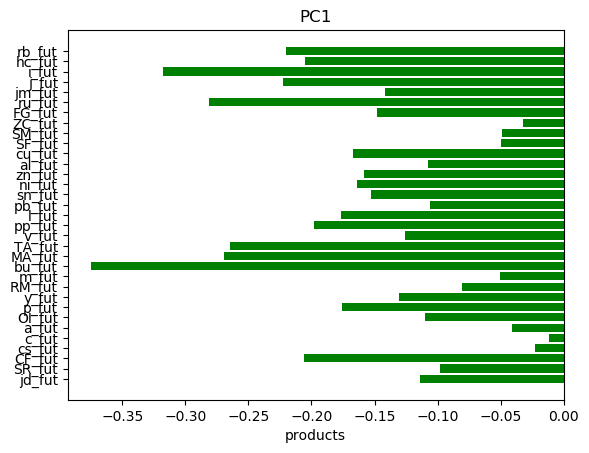

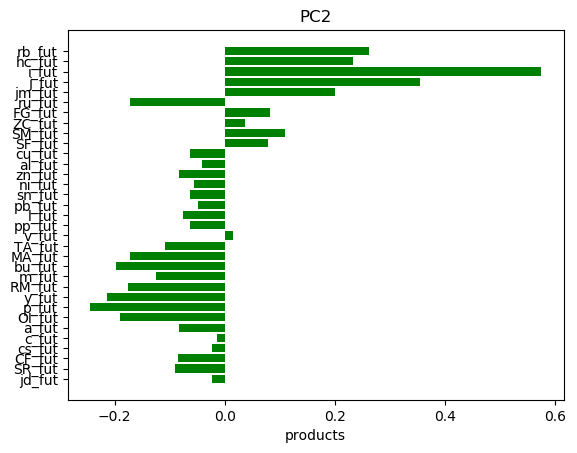

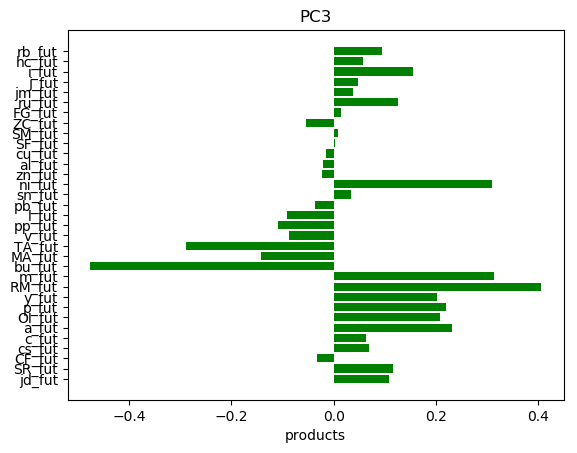

In [19]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(selected_logret.columns))
ax.barh(y_pos, pca.components_[0], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(selected_logret.columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('products')
ax.set_title('PC1')
plt.show()

fig, ax = plt.subplots()
y_pos = np.arange(len(selected_logret.columns))
ax.barh(y_pos, pca.components_[1], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(selected_logret.columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('products')
ax.set_title('PC2')
plt.show()

fig, ax = plt.subplots()
y_pos = np.arange(len(selected_logret.columns))
ax.barh(y_pos, pca.components_[2], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(selected_logret.columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('products')
ax.set_title('PC3')
plt.show()

In [20]:
col_list = ['rb_fut', 'hc_fut', 'i_fut', 'j_fut', 'jm_fut'] #, 'ZC_fut', 'ru_fut', 'ni_fut', 'cu_fut', 'pp_fut', 'SM_fut']
pca2 = PCA(n_components=5)
pca2.fit(selected_logret[col_list].dropna())
explained_ratio2 = pca2.explained_variance_ratio_
print explained_ratio2
print(pca2.components_)  

[0.68787064 0.17272748 0.08831853 0.04191579 0.00916756]
[[-0.40113838 -0.36160059 -0.66454665 -0.44294743 -0.26553405]
 [-0.20228995 -0.21905824  0.7235338  -0.50630632 -0.36227753]
 [ 0.52433418  0.55258732 -0.18361935 -0.3379331  -0.52135024]
 [ 0.12706998  0.15719825 -0.01379633 -0.65765848  0.72555972]
 [-0.71210509  0.70085267  0.03114787  0.02716645 -0.00191529]]


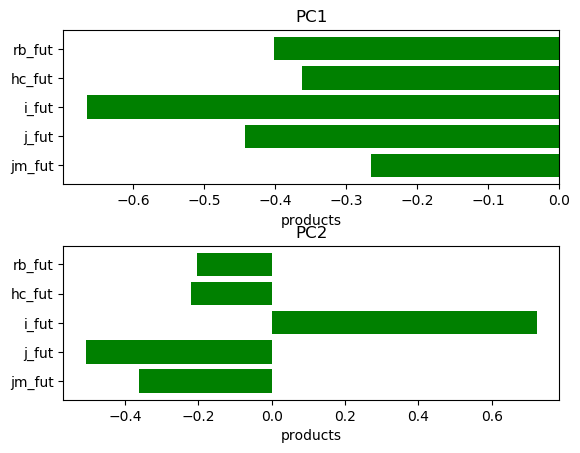

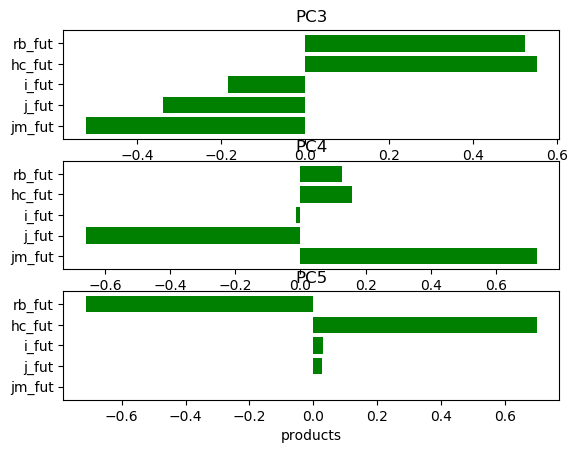

In [21]:
plt.rcdefaults()
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
y_pos = np.arange(len(col_list))
ax = fig.add_subplot(2, 1, 1)
ax.barh(y_pos, pca2.components_[0], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(col_list)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('products')
ax.set_title('PC1')

ax = fig.add_subplot(2, 1, 2)
y_pos = np.arange(len(col_list))
ax.barh(y_pos, pca2.components_[1], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(col_list)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('products')
ax.set_title('PC2')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(3, 1, 1)
y_pos = np.arange(len(col_list))
ax.barh(y_pos, pca2.components_[2], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(col_list)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('products')
ax.set_title('PC3')

ax = fig.add_subplot(3, 1, 2)
y_pos = np.arange(len(col_list))
ax.barh(y_pos, pca2.components_[3], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(col_list)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('products')
ax.set_title('PC4')

ax = fig.add_subplot(3, 1, 3)
y_pos = np.arange(len(col_list))
ax.barh(y_pos, pca2.components_[4], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(col_list)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('products')
ax.set_title('PC5')
plt.show()